In [2]:
import torch
from torch import nn
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
n_samples = 1000
X,y = make_circles(n_samples=n_samples, noise=0.05, random_state=42)
len(X), len(y)

(1000, 1000)

In [4]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7422,  0.2467],
         [-0.7340,  0.1687],
         [-0.8299,  0.2220],
         [-0.4291,  0.6722],
         [ 0.4456, -0.8949]]),
 tensor([1., 1., 1., 1., 0.]))

In [5]:
print(f"first 5 samples of X {X[:5]}")
print(f"first 5 samples of y {y[:5]}")

first 5 samples of X tensor([[ 0.7422,  0.2467],
        [-0.7340,  0.1687],
        [-0.8299,  0.2220],
        [-0.4291,  0.6722],
        [ 0.4456, -0.8949]])
first 5 samples of y tensor([1., 1., 1., 1., 0.])


In [6]:
circles = pd.DataFrame({"X1" : X[:, 0], "X2" : X[:,1], "label" : y})
circles.head(20)

,X1,X2,label
0,0.742207,0.246686,1.0
1,-0.734032,0.168692,1.0
2,-0.829859,0.221959,1.0
3,-0.429136,0.672230,1.0
4,0.445602,-0.894936,0.0
5,-0.469885,0.708037,1.0
6,-0.016045,0.805623,1.0
7,0.759623,0.159526,1.0
8,-0.175692,-0.799837,1.0
9,-0.110616,1.042207,0.0


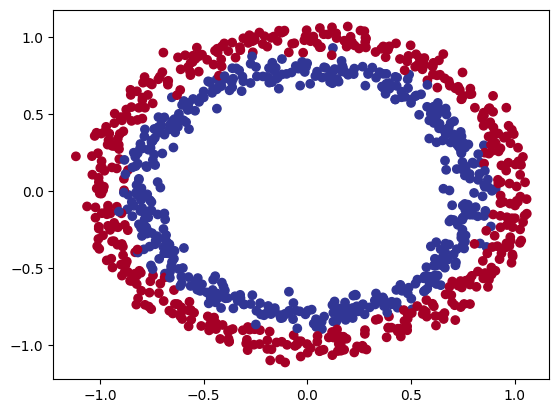

In [7]:

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [9]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    def forward(self, x):
        return self.layer_2(self.layer_1(x))


model_0 = CircleModelV0().to(device="cuda")
model_0
    


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [10]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimzer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)


In [12]:
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct / len(y_preds)) * 100
    return acc 

In [13]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits
    

tensor([[-6.0088e-02],
        [-2.7129e-02],
        [-2.5175e-01],
        [ 3.3677e-06],
        [-4.1364e-01]])

In [14]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4850],
        [0.4932],
        [0.4374],
        [0.5000],
        [0.3980]])

In [15]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [1.],
        [0.]])

In [16]:
torch.manual_seed(42)

epochs = 400

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_preds=y_pred)

    optimzer.zero_grad()

    loss.backward()

    optimzer.step()

    # testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_pred)
        
        print(f"Epoch: {epoch} |  Train loss: {loss:.5f} | Train acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

Epoch: 0 |  Train loss: 0.70106 | Train acc: 48.50% | Test loss: 0.70452 | Test acc: 47.00%
Epoch: 1 |  Train loss: 0.70053 | Train acc: 46.75% | Test loss: 0.70406 | Test acc: 45.50%
Epoch: 2 |  Train loss: 0.70005 | Train acc: 44.88% | Test loss: 0.70364 | Test acc: 43.50%
Epoch: 3 |  Train loss: 0.69961 | Train acc: 43.75% | Test loss: 0.70326 | Test acc: 41.50%
Epoch: 4 |  Train loss: 0.69919 | Train acc: 42.62% | Test loss: 0.70290 | Test acc: 40.50%
Epoch: 5 |  Train loss: 0.69881 | Train acc: 42.38% | Test loss: 0.70257 | Test acc: 38.50%
Epoch: 6 |  Train loss: 0.69846 | Train acc: 41.88% | Test loss: 0.70227 | Test acc: 38.50%
Epoch: 7 |  Train loss: 0.69813 | Train acc: 42.75% | Test loss: 0.70198 | Test acc: 39.50%
Epoch: 8 |  Train loss: 0.69783 | Train acc: 44.00% | Test loss: 0.70172 | Test acc: 39.50%
Epoch: 9 |  Train loss: 0.69755 | Train acc: 45.62% | Test loss: 0.70148 | Test acc: 41.50%
Epoch: 10 |  Train loss: 0.69729 | Train acc: 45.75% | Test loss: 0.70126 | Test

In [17]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
    

In [18]:
model_1 = CircleModelV1().to(device="cuda")
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [21]:
loss_fn_1 = nn.BCEWithLogitsLoss()



optimizer = torch.optim.SGD(params=model_1.parameters(), 
                           lr=0.1)




In [23]:
# Ensure all tensors and the model are on the same device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Move data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Move the model to the device
model_1 = CircleModelV1().to(device)

# Training loop
epochs = 1000
for epoch in range(epochs):
    # Training phase
    model_1.train()
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)  # Ensure logits and labels are on the same device
    acc = accuracy_fn(y_true=y_train, y_preds=y_preds)

    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

    # Evaluation phase
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(
            test_logits, y_test
        )  # Ensure logits and labels are on the same device
        test_acc = accuracy_fn(y_true=y_test, y_preds=test_preds)

        if epoch % 10 == 0:
            print(
                f"Epoch: {epoch} | Train loss: {loss:.5f} | Train acc: {acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%"
            )

Epoch: 0 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 10 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 20 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 30 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 40 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 50 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 60 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 70 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 80 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 90 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test acc: 50.50%
Epoch: 100 | Train loss: 0.69532 | Train acc: 51.25% | Test loss: 0.69252 | Test 

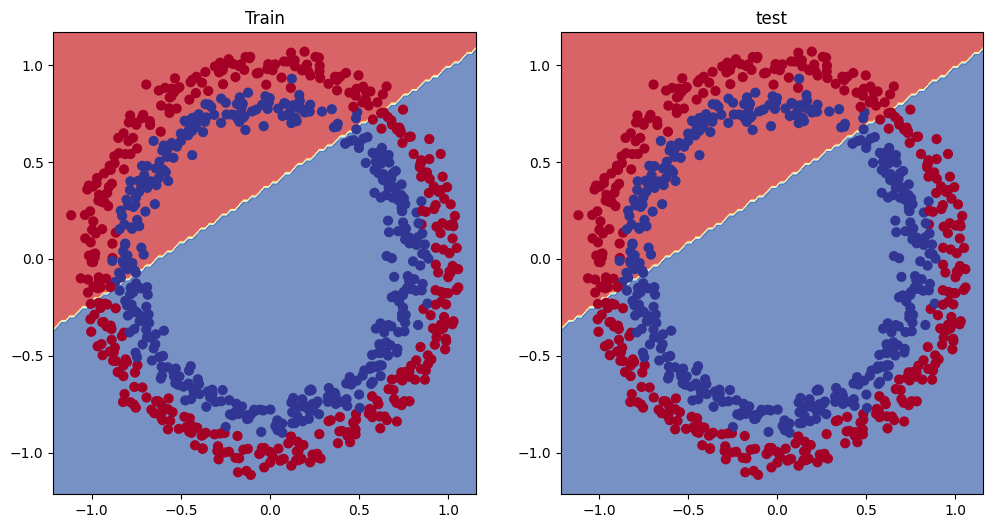

In [24]:
# plot the decision boundary
from helper_functions import plot_decision_boundary


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("test")
plot_decision_boundary(model_1, X_train, y_train)